Run below for the FULL feature engineered file with SOFA, NEWS, qSOFA, temporal sliding windows. If you're wanting feature reduction you need to also run the ones below this. 

In [1]:
from pathlib import Path

def find_project_root(marker=".gitignore"):
    """
    walk up from the current working directory until a directory containing the
    specified marker (e.g., .gitignore) is found.
    """
    current = Path.cwd()
    for parent in [current] + list(current.parents):
        if (parent / marker).exists():
            return parent.resolve()
    raise FileNotFoundError(f"Project root marker '{marker}' not found starting from {current}")
  

## Pre-processing

In [3]:

import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

root = find_project_root()
INPUT_DATASET = f"{root}/dataset/Fully_imputed_dataset.parquet"
OUTPUT_DATASET = f"{root}/dataset/preprocessed_data.parquet"

df = pd.read_parquet(INPUT_DATASET)

# file_path_NANS = "dataset/raw_combined_data.parquet"
# df2 = pd.read_parquet(file_path_NANS)

df.head()

max_length = df.groupby("patient_id").size().max()

# Score Calculation
def calculate_sofa(row):
    sofa = 0

    def assign_score(value, thresholds):
        for threshold, score in thresholds:
            if value >= threshold:
                return score
        return 0  

    # Respiration 
    if row.get('FiO2', 0) > 0:
        pao2_fio2 = row.get('SaO2', 0) / row['FiO2']
        sofa += assign_score(pao2_fio2, [(100, 4), (200, 3), (300, 2), (400, 1)])

    # Coagulation
    sofa += assign_score(row.get('Platelets', float('inf')), [(20, 4), (50, 3), (100, 2), (150, 1)])

    # Liver Function
    sofa += assign_score(row.get('Bilirubin_total', 0), [(12, 4), (6, 3), (2, 2), (1.2, 1)])

    # Cardiovascular
    if row.get('MAP', 100) < 70:
        sofa += 1

    # Renal Function
    sofa += assign_score(row.get('Creatinine', 0), [(5, 4), (3.5, 3), (2, 2), (1.2, 1)])

    return sofa

def calculate_news(row):
    news = 0

    def assign_news_score(value, thresholds):
        for threshold, score in thresholds:
            if value >= threshold:
                return score
        return 0  

    # HR (Heart Rate)
    news += assign_news_score(row.get('HR', 0), [(40, 3), (50, 1), (90, 0), (110, 1), (130, 2), (131, 3)])

    # Respiration Rate
    news += assign_news_score(row.get('Resp', 0), [(8, 3), (9, 1), (11, 0), (21, 2), (24, 3)])

    # Temperature
    news += assign_news_score(row.get('Temp', 0), [(35, 3), (36, 1), (38, 1), (39.1, 2)])

    # SBP (Systolic BP) or MAP (Mean Arterial Pressure)
    sbp = row.get('SBP', row.get('MAP', 100))
    news += assign_news_score(sbp, [(90, 3), (100, 2), (110, 1)])

    # O2 Saturation
    news += assign_news_score(row.get('O2Sat', 0), [(85, 3), (91, 2), (93, 1)])

    # Supplemental Oxygen (if available)
    if row.get('FiO2', 0) > 0.21:
        news += 2

    return news

def calculate_qsofa(row):
    qsofa = 0

    # SBP ≤ 100 mmHg
    if row.get('SBP', 120) <= 100:
        qsofa += 1

    # Respiration Rate ≥ 22
    if row.get('Resp', 0) >= 22:
        qsofa += 1

    return qsofa

def num_recorded_values(row):
    recorded_measurements = df.notnull().sum()

    return recorded_measurements

def missingness_feature(row):
    
    if 'ICULOS' and 'ICULOS' in df.columns:
        df = df.sort_values(by='ICULOS')
        time_intervals = df['ICULOS'].diff()

    return time_intervals


def add_temporal_features(df):
    #Adds rolling statistics (moving averages, standard deviation, rate of change) for some features (may or may not be useful).
    time_window_sizes = [3, 6, 12]  # Rolling window sizes (in time steps)
    feature_cols = ['HeartRate', 'RespiratoryRate', 'MAP', 'SpO2', 'Creatinine', 'Platelets']

    df.sort_values(['patient_id', 'ICULOS'], inplace=True)

    for col in feature_cols:
        if col in df.columns:
            for window in time_window_sizes:
                df[f'{col}_MA_{window}h'] = df.groupby('patient_id')[col].transform(lambda x: x.rolling(window, min_periods=1).mean())
                df[f'{col}_SD_{window}h'] = df.groupby('patient_id')[col].transform(lambda x: x.rolling(window, min_periods=1).std())
                df[f'{col}_Delta'] = df.groupby('patient_id')[col].diff()
    return df

def preprocess_data(output_file):
    global df 

    df['SOFA'] = df.apply(calculate_sofa, axis=1)
    df['NEWS'] = df.apply(calculate_news, axis=1)
    df['qSOFA'] = df.apply(calculate_qsofa, axis=1)
    #df['num_recorded_values'] = df.apply(num_recorded_values, axis=1)
    #df['missingness_feature'] = df.apply(missingness_feature, axis=1)
    df = add_temporal_features(df)

    if 'Gender' in df.columns:
        df['Gender'] = LabelEncoder().fit_transform(df['Gender'].astype(str))

    feature_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    scaler = MinMaxScaler()
    df[feature_cols] = scaler.fit_transform(df[feature_cols])
    
    # drop columns that are not needed
    columns_to_drop = ["Unit1", "Unit2", "cluster_id", "dataset", "HospAdmTime"]
    df = df.drop(columns=columns_to_drop)
    
    # NOTE: handle nan values doing forward fill and then back fill
    df = df.fillna(method="ffill")
    df = df.fillna(method="bfill")

    df.to_parquet(output_file, index=False)

    print(f"Preprocessed data saved to {output_file}")


preprocess_data(OUTPUT_DATASET)

/var/folders/8z/9lk7_58n1dzgvd97cfqznmxc0000gn/T/ipykernel_60702/2301778154.py:144: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill")
/var/folders/8z/9lk7_58n1dzgvd97cfqznmxc0000gn/T/ipykernel_60702/2301778154.py:145: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="bfill")


Preprocessed data saved to /Users/damianstone/Documents/Code/machine-learning/dl-sepsis-prediction/dataset/preprocessed_data.parquet


## PCA
If you're wanting the PCA analysis dataset run the code below to save it as pca_preprocessed.parquet in YOUR files (Github says file too large now)

HR                  0.004411
O2Sat               0.001458
Temp                0.000270
SBP                 0.006689
MAP                 0.003336
                      ...   
Platelets_Delta     0.000067
Platelets_MA_6h     0.000632
Platelets_SD_6h     0.000689
Platelets_MA_12h    0.000599
Platelets_SD_12h    0.000933
Length: 61, dtype: float64
HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP                 float64
                     ...   
Platelets_Delta     float64
Platelets_MA_6h     float64
Platelets_SD_6h     float64
Platelets_MA_12h    float64
Platelets_SD_12h    float64
Length: 61, dtype: object
Original Features: 61, Reduced Features: 41
[[ 0.97654656 -3.37071558  0.27393235 ... -0.07657595 -0.19667958
   0.04017104]
 [-0.02744637 -3.45372576  0.50251418 ...  0.05370309 -0.22450145
   0.52658785]
 [ 0.54485167 -3.40532908  0.26575782 ... -0.05130886 -0.31221618
   0.20478049]
 ...
 [ 0.14710359 -2.04733016 -0

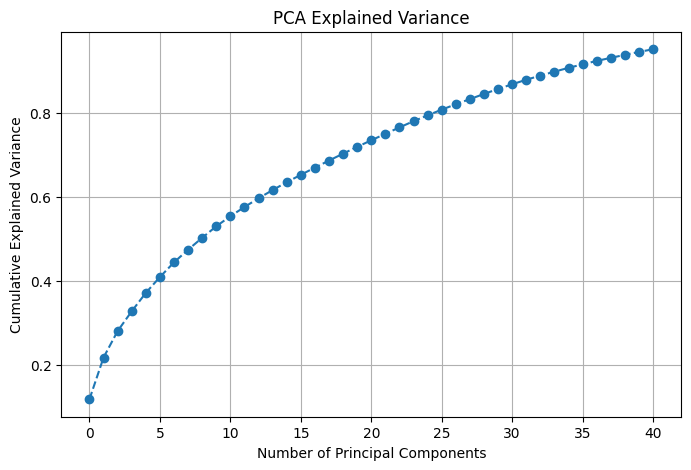

In [6]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

root = find_project_root()
INPUT_DATASET = f"{root}/dataset/preprocessed_data.parquet"
OUTPUT_DATASET = f"{root}/dataset/pca_preprocessed_data.parquet"

df = pd.read_parquet(INPUT_DATASET)

keep_columns = ["SepsisLabel", "patient_id"]
stored_columns = df[keep_columns].copy()

# PCA process
X = df.drop(columns=keep_columns)
print(X.var())
print(X.dtypes)
y = df["SepsisLabel"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Original Features: {X.shape[1]}, Reduced Features: {X_pca.shape[1]}")
print(X_pca)

# Plot
explained_variance_ratio = pca.explained_variance_ratio_
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(explained_variance_ratio), marker="o", linestyle="--")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid()
plt.show()

# Create final DataFrame with all columns
X_pca_df = pd.DataFrame(X_pca)
# Add back the stored columns
for col in keep_columns:
    X_pca_df[col] = stored_columns[col]

# Save complete DataFrame
X_pca_df.to_parquet(OUTPUT_DATASET, index=False)

## Feature selection
Run below for feature selection, this is based on SHAP values + preliminary model training to see which features were most impactful + what is the optimal number of features

In [ ]:

file_path = "preprocessed_data.parquet" 
df = pd.read_parquet(file_path)

X = df.drop(columns=["SepsisLabel", "patient_id", "dataset", "cluster_id", "Unit2", "Gender", "Platelets_Delta", "Creatinine_Delta", "Platelets_SD_3h", "Hct", "MAP_Delta", "MAP_SD_3h", "Creatinine_MA_3h", "Creatinine_SD_3h", "Platelets"])
X = X.fillna(method="bfill")
X.to_parquet("feature_selection_preprocessed.parquet", index=False)